In [11]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

In [10]:
class CovidTimeSeries(object):
    """ Stores the JHU time series data for a county for covid """
    def __init__(self):
        self.regionCode= None
        self.regionName=None
        self.positive=None
        self.Lat=None
        self.Long=None
        self.Combined_Key=None
        self.healed=None
        self.totalCases=None
        self.tested = None
        self.deaths=None

class CovidDatabase(object):
    """ Stores the covid-19 data"""
    def __init__(self):
        self.CovidData={}
        self.DateRange=[]
      
    def loadTimeSeries(self, filenameI, startdate, enddate):
        """ load the infections data from filenameI and death data from filenameD
            from startdate to enddate
        """
        csvfile=open(filenameI, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd:
                data.append(lv)

        header=data[0]
        
        infectionData=(data[1:])
        temp = np.array(infectionData)
        dates = temp[:,0]
        dates = dates.tolist()


        startdate_index=dates.index(startdate)
        enddate_index=dates.index(enddate)
       

        CountyD={}
        N=len(infectionData);
        for i in range(N):
            if not startdate<= infectionData[i][0] <= enddate:
                continue
            if int(float(infectionData[i][2])) not in CountyD:
            
                c1=CovidTimeSeries()
                c1.regionCode = infectionData[i][2]
                c1.regionName = infectionData[i][3]
                c1.Lat = float(infectionData[i][4])
                c1.Long = float(infectionData[i][5])
                dRange = enddate_index - startdate_index + 1
                fp=infectionData[i][2]
                x=int(float(fp))
                c1.deaths = [float(infectionData[i][14])]
                c1.positive = [float(infectionData[i][10])]
                c1.totalCases = [float(infectionData[i][17])]
                c1.healed = [float(infectionData[i][13])]
                if(infectionData[i][19] == ''):
                    c1.tested = [float('0')]
                else:
                    c1.tested = [float(infectionData[i][19])]
                CountyD[x]=c1
            else:
                fp=infectionData[i][2]
                x=int(float(fp))
                CountyD[x].positive.append(float(infectionData[i][10]))
                CountyD[x].deaths.append(float(infectionData[i][14]))
                CountyD[x].totalCases.append(float(infectionData[i][17]))
                CountyD[x].healed.append(float(infectionData[i][13]))
                if(infectionData[i][19] == ''):
                    CountyD[x].tested.append(float('0'))
                else:
                    CountyD[x].tested.append(float(infectionData[i][19]))
        for key in CountyD:
            CountyD[key].deaths = np.array(CountyD[key].deaths)
            CountyD[key].positive = np.array(CountyD[key].positive)
            CountyD[key].healed = np.array(CountyD[key].healed)
            CountyD[key].totalCases = np.array(CountyD[key].totalCases)
            CountyD[key].tested = np.array(CountyD[key].tested)
             
        self.DateRange=dates
        self.CovidData=CountyD
        

In [9]:
# Modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc="..\\Data\\"
elif platform.system() == "Linux":
    pathc="../Data/"

fullDataName="dpc-covid19-ita-regioni.csv"

startdate='2020-02-24T18:00:00'
enddate='2021-05-18T17:00:00'

database=CovidDatabase();
database.loadTimeSeries(pathc+fullDataName, startdate, enddate)

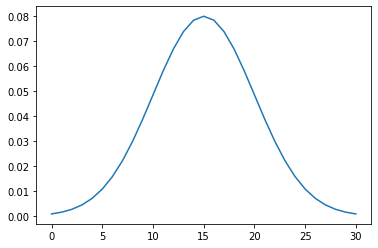

In [10]:
sigma = 5
conSize = 15
x2 = np.arange(-conSize, 1 + conSize)
kernel2 = np.exp(-(x2) ** 2 / (2 * sigma ** 2))
kernel2=kernel2/sum(kernel2)
plt.plot(kernel2)

450


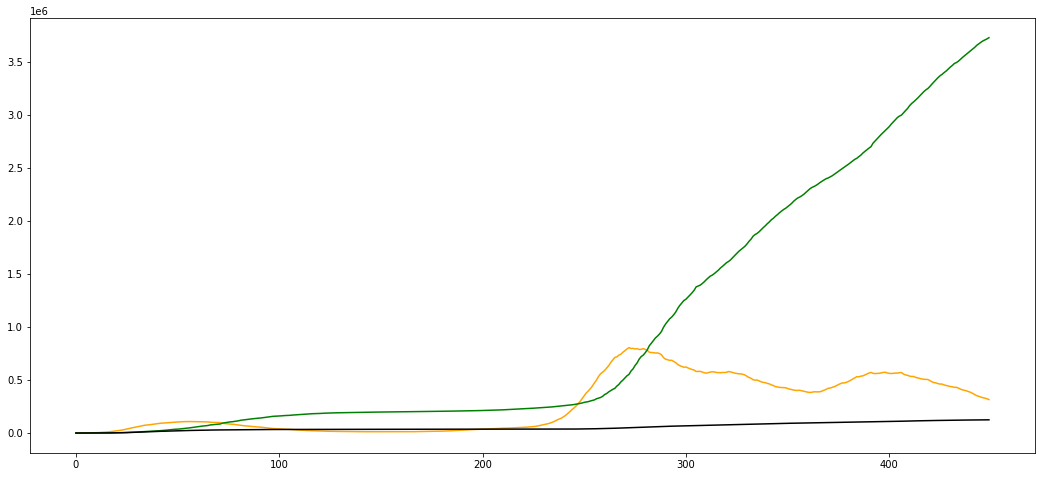

In [12]:
CountyD=database.CovidData
[N] = np.shape(CountyD[13].positive)
print(N)
infectRaw = [0] * N
recovRaw = [0] * N
deadRaw = [0] * N
natTested = [0] * N
for key in CountyD:
    infectRaw += CountyD[key].positive
    recovRaw += CountyD[key].healed
    deadRaw += CountyD[key].deaths
    natTested += CountyD[key].tested
popITA = 60000000
susceptRaw = popITA - infectRaw - recovRaw - deadRaw

fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
#ax.plot(natTested, color = 'red', label = 'tested') #graphing tested makes the scaling hard to visualize
ax.plot(infectRaw, color='orange', label='infected')
ax.plot(recovRaw, color='green', label='recovered')
ax.plot(deadRaw, color='black', label='dead')

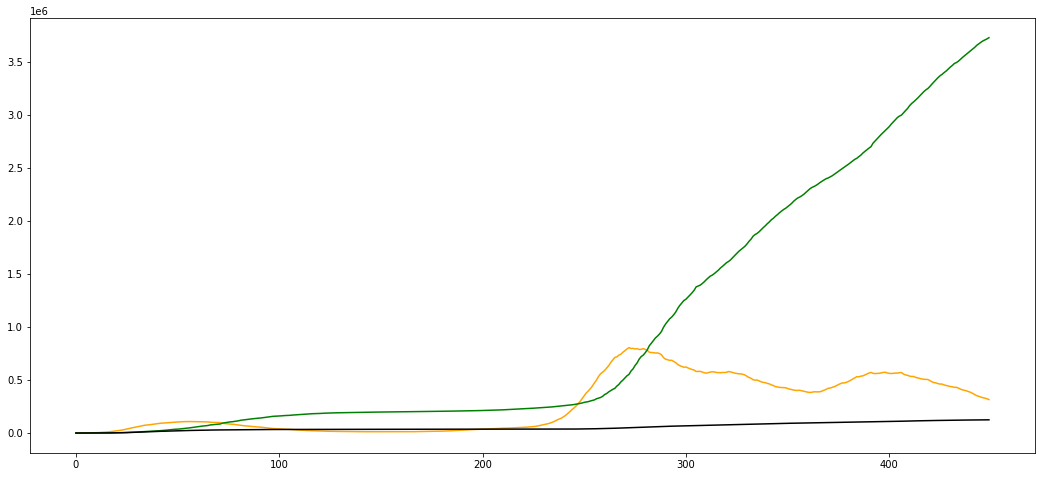

In [13]:
#option for use of raw numbers for data, no smoothing
infect = infectRaw
recov = recovRaw
dead = deadRaw
suscept = susceptRaw

#convolve the data to smooth out, valid mode keeps bound points realistic
#infect = np.convolve(infectRaw, kernel2, 'valid')
#recov = np.convolve(recovRaw, kernel2, 'valid')
#dead = np.convolve(deadRaw, kernel2, 'valid')
#suscept = popITA - infect - recov - dead #S + I + R + D = totalPop

fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
ax.plot(infect, color='orange', label='infected')
ax.plot(recov, color='green', label='recovered')
ax.plot(dead, color='black', label='dead')

### Modeling $\gamma$ (recovery rate), $\beta$ (transmission rate), and $\upsilon$ (death rate).

$S(t+1) = -\beta \frac{S(t)I(t)}{S(t)+I(t)} + S(t)$

$I(t+1) = \beta \frac{S(t)I(t)}{S(t)+I(t)} - \gamma I(t) - \upsilon I(t) + I(t)$

$R(t+1) = \gamma I(t) + R(t)$

$D(t+1) = \upsilon I(t) + D(t)$

### As a matrix

$\begin{bmatrix}
S(t+1) \\ I(t+1) \\ R(t+1) \\ D(t+1)
\end{bmatrix}
=
\begin{bmatrix}
S(t) & -\frac{S(t)I(t)}{S(t)+I(t)} & 0 & 0 \\
I(t) & \frac{S(t)I(t)}{S(t)+I(t)} & -I(t) & -I(t) \\
R(t) & 0 & I(t) & 0 \\
D(t) & 0 & 0 & I(t)
\end{bmatrix}
\begin{bmatrix}
1 \\ \beta \\ \gamma \\ \upsilon
\end{bmatrix}$

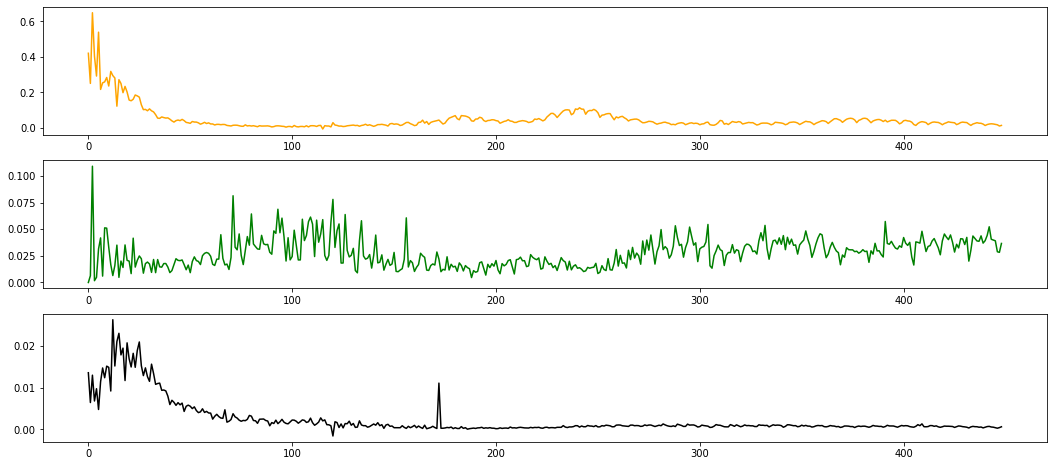

In [14]:
sirdMatrix = np.zeros((len(recov) - 1, 4, 4))
nextIterMatrix = np.zeros((len(recov) - 1, 4, 1)) #the S(t+1), I(t+1), ... matrix

#populate the 4x4 matrix with parameters (see above note)
sirdMatrix[:,0,0] = suscept[0:-1]
sirdMatrix[:,0,1] = -(suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])

sirdMatrix[:,1,0] = infect[0:-1]
sirdMatrix[:,1,1] = (suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])
sirdMatrix[:,1,2] = -infect[0:-1]
sirdMatrix[:,1,3] = -infect[0:-1]

sirdMatrix[:,2,0] = recov[0:-1]
sirdMatrix[:,2,2] = infect[0:-1]

sirdMatrix[:,3,0] = dead[0:-1]
sirdMatrix[:,3,3] = infect[0:-1]

#populate the S(t+1), I(t+1), ... matrix
nextIterMatrix[:,0,0] = suscept[1:]
nextIterMatrix[:,1,0] = infect[1:]
nextIterMatrix[:,2,0] = recov[1:]
nextIterMatrix[:,3,0] = dead[1:]

paramMatrix = np.linalg.solve(sirdMatrix, nextIterMatrix) #solve Ax = B, where A = sirdMatrix, and B = nextIterMatrix

#copy params over from the solved matrix
transRate = paramMatrix[:,1,0] #beta
recovRate = paramMatrix[:,2,0] #gamma
deathRate = paramMatrix[:,3,0] #upsilon

#plot rates over time
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRate, color='orange', label='Transmission Rate')
ax[1].plot(recovRate, color='green', label='Recovery Rate')
ax[2].plot(deathRate, color='black', label='Death Rate')

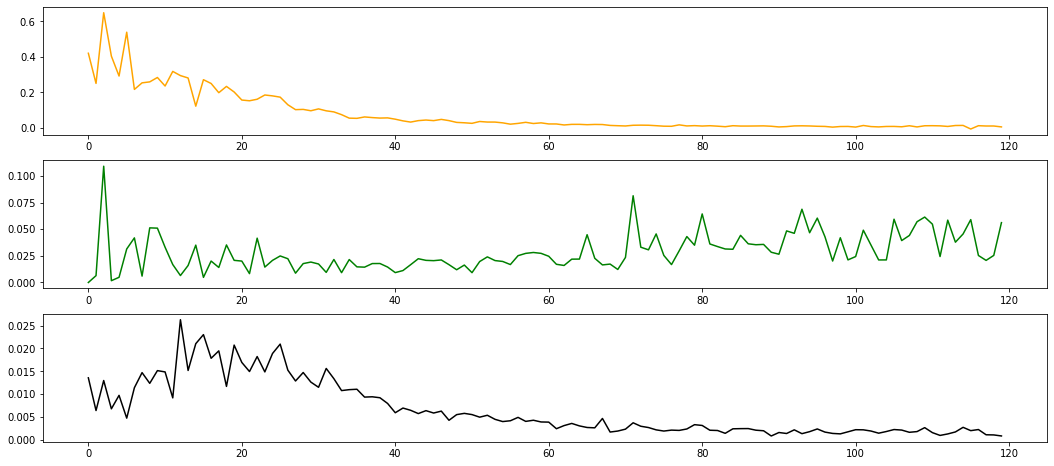

In [15]:
#graph only the first ~100-120 days (remember the first some days are removed when smoothing)
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRate[0:120], color='orange', label='Transmission Rate')
ax[1].plot(recovRate[0:120], color='green', label='Recovery Rate')
ax[2].plot(deathRate[0:120], color='black', label='Death Rate')